# Project 4 - Vehicle Detection

## Classification Pipeline

### Load Libraries

In [45]:
# import libaries
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import numpy as np
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import glob
import time
import pickle
from skimage.feature import hog
from lessonFunctions import *

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC, SVC
from sklearn.externals import joblib
from sklearn.model_selection import cross_val_score, cross_val_predict

%matplotlib inline

print('Libraries Imported!')

Libraries Imported!


### Load Image Database

In [6]:
cars = glob.glob('./images/vehicles/**/*.png', recursive=True)
notCars = glob.glob('./images/non-vehicles/**/*.png', recursive=True)

print('Number of Car Images: ', len(cars))
print('Number of Non Car Images: ',len(notCars))

Number of Car Images:  8792
Number of Non Car Images:  8968


#### Plot Examples of Database

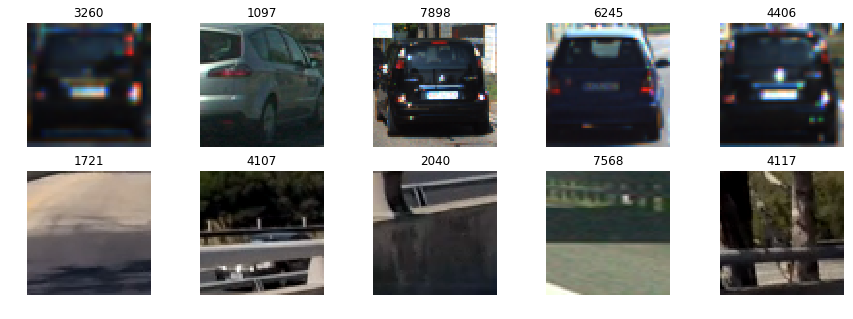

In [7]:
# Show Random Examples
def plotExamples():
    plt.figure(figsize=(15,5))
    
    for i in range(5):
        carIdx = np.random.randint(0,len(cars))
        notCarIdx = np.random.randint(0,len(notCars))
        car = mpimg.imread(cars[carIdx])
        notCar = mpimg.imread(notCars[notCarIdx])
        
        plt.subplot(2,5,i+1)
        plt.imshow(car)
        plt.axis('off')
        plt.title(carIdx)
        plt.subplot(2,5,5+i+1)
        plt.imshow(notCar)
        plt.axis('off')
        plt.title(notCarIdx)
interact_manual(plotExamples)

## Feature Extraction

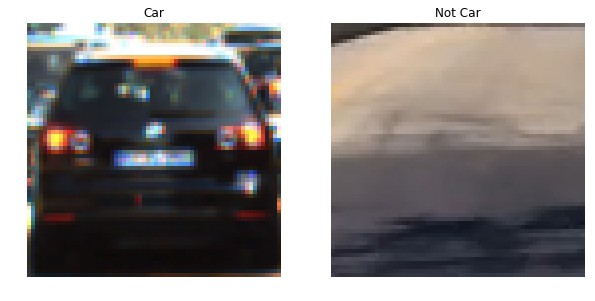

In [53]:
# Load Test Images
testImg_Car = cv2.imread(cars[8231])
testImg_NotCar = cv2.imread(notCars[1721])

# convert to RGB
testImg_Car = cv2.cvtColor(testImg_Car, cv2.COLOR_BGR2RGB)
testImg_NotCar = cv2.cvtColor(testImg_NotCar, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(testImg_Car)
plt.axis('off')
plt.title('Car')
plt.subplot(122)
plt.imshow(testImg_NotCar)
plt.axis('off')
plt.title('Not Car')
plt.show()

### Color Spaces & Spatial Binning

In [9]:
def plot3d(pixels, colors_rgb, axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation

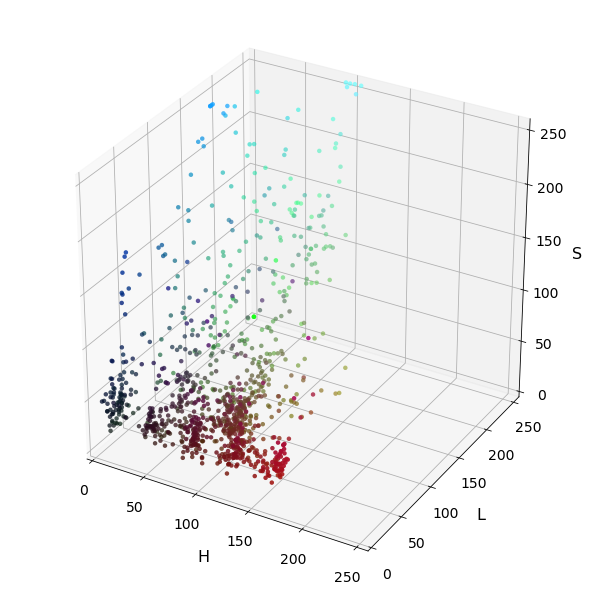

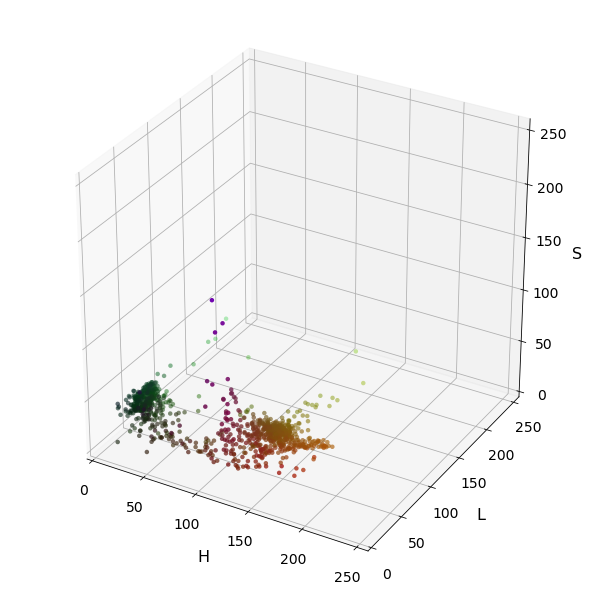

In [12]:
def fSpatialColorSpace(colorSpace):
    newImage = convertCSpace(testImg_Car, colorSpace)
    featureVec_Car = bin_spatial(newImage, unravel=False)
    
    newImage = convertCSpace(testImg_NotCar, colorSpace)
    featureVec_NotCar = bin_spatial(newImage, unravel=False)
    scaledFeatures_Car = featureVec_Car/255
    scaledFeatures_NotCar = featureVec_NotCar/255
    
    plot3d(featureVec_Car, scaledFeatures_Car, axis_labels=list(colorSpace))
    plt.show()
    plot3d(featureVec_NotCar, scaledFeatures_NotCar, axis_labels=list(colorSpace))
    plt.show()

interact(fSpatialColorSpace, colorSpace={'HSV':'HSV', 'LUV':'LUV','HLS':'HLS','YUV':'YUV','YCrCb':'YCrCb', 'RGB':'RGB'})

### Histogram Extraction

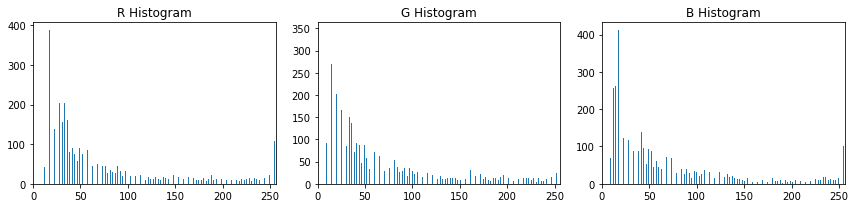

In [14]:
# Interact with color hist
def fColorHist(nbins):
    rhist, ghist, bhist, bin_centers, hist_features = color_hist(testImg_Car, nbins)
    if rhist is not None:
        fig = plt.figure(figsize=(12,3))
        plt.subplot(131)
        plt.bar(bin_centers, rhist[0])
        plt.xlim(0, 256)
        plt.title('R Histogram')
        plt.subplot(132)
        plt.bar(bin_centers, ghist[0])
        plt.xlim(0, 256)
        plt.title('G Histogram')
        plt.subplot(133)
        plt.bar(bin_centers, bhist[0])
        plt.xlim(0, 256)
        plt.title('B Histogram')
        fig.tight_layout()
        plt.show()
interact(fColorHist, nbins=32)

### HOG Transform

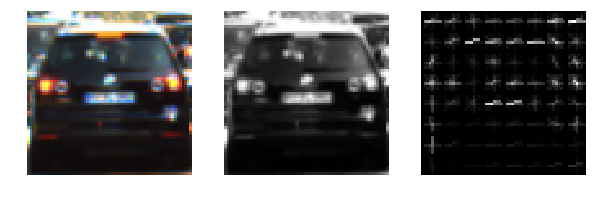

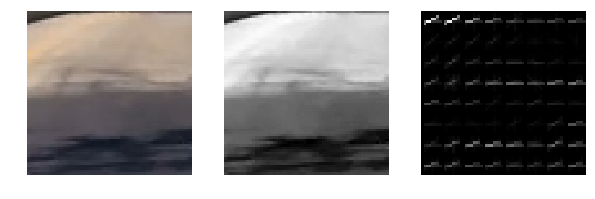

In [55]:
def fHog(colorSpace='RGB', pixPerCell=8, cellPerBlock=2, orients=9, hogChannel=0):
    plt.figure(figsize=(10,10))
    plt.subplot(131)
    plt.imshow(testImg_Car)
    plt.axis('off')
    img = convertCSpace(testImg_Car, colorSpace)
    plt.subplot(132)
    plt.imshow(img[:,:,hogChannel], cmap='gray')
    plt.axis('off')
    _, hog_image = get_hog_features(img[:,:,hogChannel], orients, pixPerCell, cellPerBlock, True)
    plt.subplot(133)
    plt.imshow(hog_image, cmap='gray')
    plt.axis('off')
    plt.show()
    
    plt.figure(figsize=(10,10))
    plt.subplot(131)
    plt.imshow(testImg_NotCar)
    plt.axis('off')
    img = convertCSpace(testImg_NotCar, colorSpace)
    plt.subplot(132)
    plt.imshow(img[:,:,hogChannel], cmap='gray')
    plt.axis('off')
    _, hog_image = get_hog_features(img[:,:,hogChannel], orients, pixPerCell, cellPerBlock, True)
    plt.subplot(133)
    plt.imshow(hog_image, cmap='gray')
    plt.axis('off')
    plt.show()
    
    
interact(fHog, colorSpace={'HSV':'HSV', 'LAB':'LAB', 'LUV':'LUV','HLS':'HLS','YUV':'YUV','YCrCb':'YCrCb', 'RGB':'RGB'}, 
             pixPerCell=(1,20), cellPerBlock=(0,9), orients=(0,20), hogChannel = (0,2))

In [17]:
# Function to get picture features
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256), 
                        orient=9, pixPerCell=8, cellPerBlock=2, hogChannel=0,
                        spatial_features=True, hist_features=True, hog_features=True):
    features=[]
    
    for img in imgs:
        image = cv2.imread(img)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Change color space
        image = convertCSpace(image, cspace)
        
        img_features = []
        # Get Spatial and histogram features
        if spatial_features:
            spatialFeatures = bin_spatial(image, spatial_size)
            img_features.append(spatialFeatures)
        if hist_features:
            _, _, _, _, histFeatures = color_hist(image, hist_bins, hist_range)
            img_features.append(histFeatures)
        # Get Hog Features
        if hog_features:
            if hogChannel == 'All':
                hogFeatures=[]
                for channel in range(image.shape[2]):
                    hogFeatures.append(get_hog_features(image[:,:,channel], 
                                        orient, pixPerCell, cellPerBlock, 
                                        vis=False, feature_vec=True))
                hogFeatures = np.ravel(hogFeatures)
            else:
                hogFeatures = get_hog_features(image[:,:,hogChannel], 
                                orient, pixPerCell, cellPerBlock, 
                                vis=False, feature_vec=True)
            img_features.append(hogFeatures)
       
        # Combine all features together
        features.append(np.concatenate(img_features))
    return features

In [38]:
# Get features from dataset
cspace = 'LAB' #'HSV','LUV',HLS','YUV','YCrCb', 'RGB'
spatial_size = (32,32)
hist_bins = 32
hist_range = (0,256)
orient = 12
pixPerCell = 8
cellPerBlock = 2
hogChannel = 'All'
spat_feat = True
hist_feat = True
hog_feat = True

t = time.time()
carFeatures = extract_features(cars, cspace, spatial_size, hist_bins, hist_range, 
                               orient, pixPerCell, cellPerBlock, hogChannel,
                                  spat_feat,hist_feat,hog_feat)
notCarFeatures = extract_features(notCars, cspace, spatial_size, hist_bins, hist_range, 
                               orient, pixPerCell, cellPerBlock, hogChannel,
                                  spat_feat,hist_feat,hog_feat)

print('Features Extracted!')
t2 = time.time()
print('Time To Extract Features: ', round(t2-t,2), ' seconds')

Features Extracted!


## Build Classifier

#### Sort, Scale and Split the Data

In [39]:
# Sort the Data
X = np.vstack((carFeatures, notCarFeatures)).astype(np.float64)

# Scale the data to make it even
scaler = StandardScaler().fit(X)
XScaled = scaler.transform(X)

# Create label vector
y = np.hstack((np.ones(len(carFeatures)), np.zeros(len(notCarFeatures))))

# Split data into training and testing sets
randState = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split( XScaled, y, 
                                        test_size=0.2, random_state=randState)
print('Data Sorted!')

Data Sorted!
Time To Extract Features:  69.36  seconds


#### Fit the Classifier

In [40]:
clf = LinearSVC(C=0.001)
t = time.time()
clf.fit(X_train, y_train)
t2 = time.time()
print('Time To Fit the Model: ', round(t2-t,2), ' seconds')

acc = round(clf.score(X_test, y_test),4)
print('Model Accuracy: ', acc)

Time To Fit the Model:  5.2  seconds
Model Accuracy:  0.987


#### Save the model to file

In [41]:
filename = './model/bestFit_{}_{}.pkl'.format(acc, cspace)
joblib.dump(clf, filename)
filename = './model/scaler_{}_{}.pkl'.format(acc, cspace)
joblib.dump(scaler, filename)

['./model/scaler_0.987_LAB.pkl']

### Cross Validation of the Model (Debugging)

In [ ]:
filename = './model/bestFit_0.9918.pkl'
svc = joblib.load(filename)
filename = './model/scaler_0.9918.pkl'
scaler = joblib.load(filename)

In [ ]:
scores = cross_val_score(svc, X_train, y_train, cv=5)
print("Accuracy: {:0.5} (+/- {:0.2})".format(scores.mean(), scores.std() * 2))